In [1]:
import pandas as pd
import numpy as np
import pyreadstat as prs
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from geopy.extra.rate_limiter import RateLimiter
import geopy
import folium
from folium.plugins import FastMarkerCluster

In [2]:
county_df = pd.read_csv("/Users/work/PycharmProjects/corona/data/nyt/covid-19-data-master/us-counties.csv")
state_df = pd.read_csv("/Users/work/PycharmProjects/corona/data/nyt/covid-19-data-master/us-states.csv")

In [5]:
date_df = county_df.groupby(["date"]).sum().reset_index()

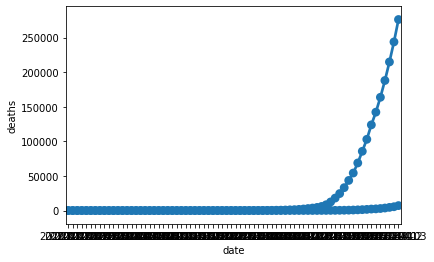

In [6]:
ax = sns.pointplot(x="date", y="cases", data=date_df)
ax = sns.pointplot(x="date", y="deaths", data=date_df)

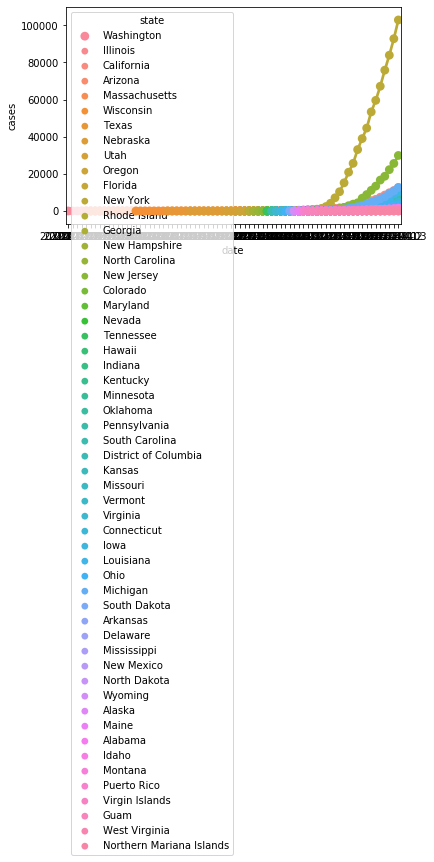

In [7]:
ax = sns.pointplot(x="date", y="cases", data=state_df, hue="state")

## Markdown

In [8]:
hospital_df = pd.read_csv("/Users/work/PycharmProjects/corona/data/hospitals/Healthcare Associated Infections - Hospital.csv")

In [9]:
print(hospital_df.shape)
hospital_df.head()

(170352, 15)


Facility ID                     Facility Name                 Address  \
0        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
1        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
2        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
3        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
4        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   

     City State  ZIP Code County Name    Phone Number       Measure ID  \
0  DOTHAN    AL     36301     HOUSTON  (334) 793-8701    HAI_1_CILOWER   
1  DOTHAN    AL     36301     HOUSTON  (334) 793-8701    HAI_1_CIUPPER   
2  DOTHAN    AL     36301     HOUSTON  (334) 793-8701       HAI_1_DOPC   
3  DOTHAN    AL     36301     HOUSTON  (334) 793-8701  HAI_1_ELIGCASES   
4  DOTHAN    AL     36301     HOUSTON  (334) 793-8701  HAI_1_NUMERATOR   

                                        Measure Name  \
0  Central Line Associated Bloodstream Infection ...   
1  Central Line Associated Bloodstream Infection ...   
2  Central Line Associated Bloodstream Infection:...   
3  Central Line Associated Bloodstream Infection ...   
4  Central Line Associated Bloodstream Infection ...   

                   Compared to National  Score Footnote  Start Date  \
0  No Different than National Benchmark  0.787      NaN  04/01/2018   
1  No Different than National Benchmark  2.761      NaN  04/01/2018   
2  No Different than National Benchmark   6631      NaN  04/01/2018   
3  No Different than National Benchmark  6.456      NaN  04/01/2018   
4  No Different than National Benchmark     10      NaN  04/01/2018   

     End Date  
0  03/31/2019  
1  03/31/2019  
2  03/31/2019  
3  03/31/2019  
4  03/31/2019

In [10]:
general_hospital_df = pd.read_csv("/Users/work/PycharmProjects/corona/data/hospitals/Hospital General Information.csv")

In [11]:
houston_df = general_hospital_df[general_hospital_df["City"]=="HOUSTON"].iloc[2:, :]

In [12]:
houston_df.head(1)

Facility ID             Facility Name                  Address     City  \
4408      450035  ST JOSEPH MEDICAL CENTER  1401 ST. JOSEPH PARKWAY  HOUSTON   

     State  ZIP Code County Name    Phone Number         Hospital Type  \
4408    TX     77002      HARRIS  (713) 757-1000  Acute Care Hospitals   

     Hospital Ownership  ... Readmission national comparison  \
4408        Proprietary  ...      Above the national average   

     Readmission national comparison footnote  \
4408                                      NaN   

     Patient experience national comparison  \
4408             Below the national average   

      Patient experience national comparison footnote  \
4408                                              NaN   

     Effectiveness of care national comparison  \
4408              Same as the national average   

      Effectiveness of care national comparison footnote  \
4408                                                NaN    

     Timeliness of care national comparison  \
4408             Below the national average   

      Timeliness of care national comparison footnote  \
4408                                              NaN   

     Efficient use of medical imaging national comparison  \
4408                       Same as the national average     

      Efficient use of medical imaging national comparison footnote  
4408                                                NaN              

[1 rows x 28 columns]

In [31]:
def compute_search_address(df):
    houston_df["wrangled_address"] = houston_df.Address.apply(lambda x: x.split(",")[0])
    df["search_address"] = df.wrangled_address + ", " + df.City + ", " + df.State + ", " + df["ZIP Code"].astype(str) + ", " + "United States of America"

def compute_location(df):
    locator = geopy.geocoders.Nominatim(user_agent="COVID19_123")
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
    df['location'] = df['search_address'].apply(geocode)
    df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
    df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

In [32]:
compute_search_address(houston_df)

In [33]:
compute_location(houston_df)

## need to scrape for proper address or change which geolocator is used to google?

In [19]:

for i,v in enumerate(houston_df.point):
    if v is None:
        print(houston_df.search_address.iloc[i])
    

2525 HOLLY HALL, HOUSTON, TX, 77054, United States of America
510 W TIDWELL, HOUSTON, TX, 77091, United States of America
2929 WOODLAND PARK DRIVE, HOUSTON, TX, 77082, United States of America
2800 MACGREGOR WAY, HOUSTON, TX, 77021, United States of America
17750 CALI DRIVE, HOUSTON, TX, 77090, United States of America
20171 CHASEWOOD PARK DRIVE, HOUSTON, TX, 77070, United States of America
9922 LOUETTA RD, HOUSTON, TX, 77070, United States of America


In [20]:
houston_df.search_address.iloc[4]

'2525 HOLLY HALL, HOUSTON, TX, 77054, United States of America'

In [21]:
locator.geocode("510 W TIDWELL Rd, HOUSTON, TX, 77091, US")

Location(West Tidwell Road, Highland Heights, Houston, Harris County, Texas, 77091, United States of America, (29.8471087, -95.4289707, 0.0))

In [239]:
print(np.median(df.latitude))
print(np.median(df.longitude))


29.726302
-95.4293302


In [35]:
df = houston_df[houston_df.point.notna()]

In [242]:
map1 = folium.Map(
    location=[np.median(df.latitude), np.median(df.longitude) ],
    tiles='cartodbpositron',
    zoom_start=10,
)
df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
    

folium.CircleMarker(location=[29.910315586977983 , -95.45300589475552 ]).add_to(map1)
map1

In [250]:
folium_map = folium.Map(
    location=[np.median(df.latitude), np.median(df.longitude) ],
    tiles='CartoDB dark_matter',
    zoom_start=10,
)
FastMarkerCluster(data=list(zip(df['latitude'].values, df['longitude'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map

In [257]:
district_geo = r"/Users/work/PycharmProjects/hfd-spring-2020/data/Uploaded_Shapefiles/CensusBlock_2010/Census_FIP12_within_Fire_Dis.geojson"

In [271]:
geo_df
map1 = folium.Map(location=[np.median(df.latitude), np.median(df.longitude)], zoom_start=10)
folium.GeoJson(
    district_geo,
    name='geojson'
).add_to(map1)
df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=5, color="red").add_to(map1), axis=1)
display(map1)

In [36]:
print(np.median(df.latitude), np.median(df.longitude))

29.726302 -95.4293302
